### 1. Import delle librerie necessarie

In [59]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

### 2. Caricamento e Preparazione dei Dati

In [60]:
# Caricamento dei dati
data = pd.read_csv('data.csv')

# Assicurati che i dati siano numerici
data = data.astype({'SampleTime': 'float64', 'SensorID': 'float64', 'Value': 'float64'})

# Visualizzazione delle prime righe per confermare il caricamento
print(data.head(5))

   SampleTime  SensorID     Value
0         0.0       2.0  0.033883
1         0.0       4.0 -0.009496
2         0.0       5.0  0.000000
3         0.0       7.0 -0.057306
4         0.0       8.0  0.029096


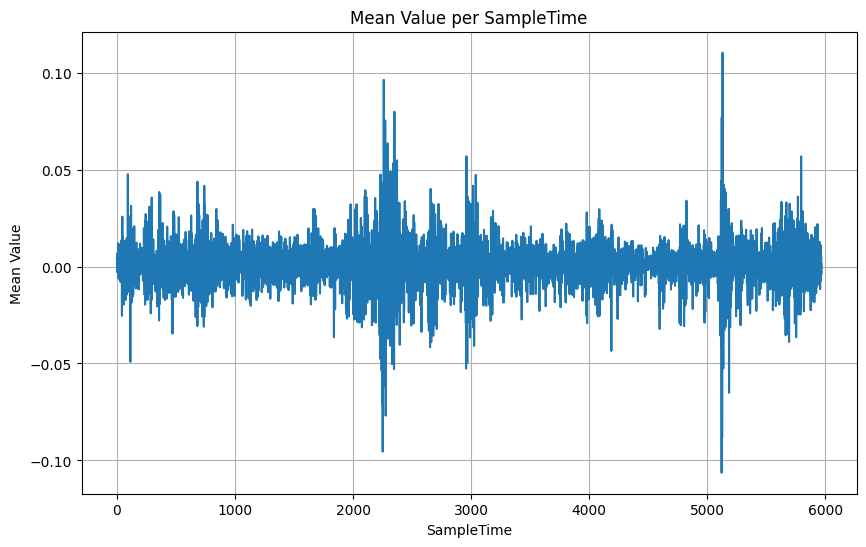

In [61]:
# Calcola la media dei valori per ogni SampleTime
mean_values = data.groupby('SampleTime')['Value'].mean()

# Plot della media dei valori per SampleTime
plt.figure(figsize=(10, 6))
plt.plot(mean_values.index, mean_values.values)
plt.xlabel('SampleTime')
plt.ylabel('Mean Value')
plt.title('Mean Value per SampleTime')
plt.grid(True)
plt.show()

### 3. Funzioni Ausiliarie

In [63]:
# Funzione ausiliaria per proiettare i dati e calcolare i residui
def project_and_compute_residuals(data, mean, principal_subspace):
    centered_data = data - mean
    projection = centered_data @ principal_subspace @ principal_subspace.T
    residuals = centered_data - projection
    return residuals / np.linalg.norm(residuals)

# Funzione principale per la fase offline
def split_and_compute_pca(X, test_size=0.5, random_state=42, variance_retained=0.95):
    """
    Divide il dataset X in due subset S1 e S2, calcola la media campionaria e la matrice di covarianza su S1,
    determina gli autovalori e autovettori della matrice di covarianza, e proietta i dati nel sottospazio principale
    calcolando i residui.

    Parameters:
    X (np.array): Il dataset da dividere.
    test_size (float): La frazione del dataset da assegnare a S2.
    random_state (int): Il seed per la riproducibilità della divisione.
    variance_retained (float): La frazione della varianza totale che si desidera trattenere nel sottospazio principale.

    Returns:
    mean (np.array): La media campionaria calcolata su S1.
    principal_subspace (np.array): La matrice contenente gli autovettori corrispondenti al sottospazio principale.
    S2 (np.array): Il subset S2.
    """
    # Dividi il dataset in due subset
    S1, S2 = train_test_split(X, test_size=test_size, random_state=random_state)
    
    # Calcola la media campionaria su S1
    mean = np.mean(S1, axis=0)
    
    # Calcola la matrice di covarianza su S1
    covariance_matrix = np.cov(S1, rowvar=False)
    
    # Calcola gli autovalori e gli autovettori della matrice di covarianza
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    
    # Ordina gli autovalori e gli autovettori in ordine decrescente di autovalori
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]
    
    # Determina la dimensionalità del sottospazio principale
    total_variance = np.sum(eigenvalues)
    variance_covered = 0
    r = 0
    while variance_covered / total_variance < variance_retained:
        variance_covered += eigenvalues[r]
        r += 1
    
    # Matrice del sottospazio principale (V)
    principal_subspace = eigenvectors[:, :r]
    
    return mean, principal_subspace, S2

# Funzione per calcolare p_t
def compute_p_t(residuals, nominal_residuals):
    p_t = np.sum(nominal_residuals > residuals) / len(nominal_residuals)
    return p_t

# Funzione per calcolare s_t
def compute_s_t(p_t, alpha):
    s_t = np.log(alpha / p_t)
    return s_t

### 4. Inizializzazione

In [64]:
# Inizializzazione delle variabili per la fase online
g_t = 0.0  # Statistica decisionale iniziale
h = 0.1  # Soglia di decisione, esempio di valore
W = 100  # Ampiezza della finestra scorrevole
t = W  # Tempo iniziale
alpha = 275  # Livello di significatività per il calcolo di s_t

# Lista per memorizzare gli istanti di tempo delle anomalie
anomalies = []
p = []
s = []
g = []

# Ottieni i valori dei sensori ordinati per SampleTime e SensorID
sensor_values = data.pivot(index='SampleTime', columns='SensorID', values='Value').fillna(0)
print(f"Dimensioni di sensor_values: {sensor_values.shape}")

Dimensioni di sensor_values: (5967, 999)


### 5. Rilevamento anomalie

In [65]:
# Inizializzazione della barra di progresso tqdm
progress_bar = tqdm(total=len(sensor_values) - W, desc='Processing data points')

# Ciclo while per la fase online
while t < len(sensor_values):
    # Ottieni il nuovo punto dati x_t
    x_t = sensor_values.iloc[t].values
    
    # Aggiorna la finestra scorrevole
    window_data = sensor_values.iloc[t-W:t].values
    
    # Chiama la fase offline sulla finestra scorrevole
    mean, principal_subspace, S2 = split_and_compute_pca(window_data, test_size=0.5, random_state=42, variance_retained=0.95)
    
    # Proietta il nuovo punto dati nel sottospazio principale e calcola i residui
    residuals = project_and_compute_residuals(np.array([x_t]), mean, principal_subspace)
    
    # Calcola i residui nominali per S2
    nominal_residuals = project_and_compute_residuals(S2, mean, principal_subspace)
    
    # Calcola p_t
    p_t = compute_p_t(residuals, nominal_residuals)
    p.append(p_t)

    if len(p) > 100:
        alpha = (sum(p[-100:]) / 100) * (92/100)
    
    # Calcola s_t
    s_t = compute_s_t(p_t, alpha)
    s.append(s_t)
    
    # Aggiorna g_t
    g_t = max(0, g_t + s_t)
    g.append(g_t)

    # Controlla se g_t supera la soglia h
    if g_t >= h:
        print(f"Anomalia rilevata al tempo t={t} con g_t={g_t}")
        print(f"Valore medio di x_t: {np.mean(x_t)}")
        anomalies.append(sensor_values.index[t])  # Salva l'istante di tempo dell'anomalia
        g_t = 0  # Resetta g_t
    
    # Aggiorna la barra di progresso
    progress_bar.update(1)
    
    t = t + 1

# Chiudi la barra di progresso
progress_bar.close()

Processing data points:   0%|          | 22/5867 [00:05<18:54,  5.15it/s]

Anomalia rilevata al tempo t=120 con g_t=0.14550933613717706
Valore medio di x_t: 0.016920226226226225


Processing data points:   1%|          | 66/5867 [00:20<48:08,  2.01it/s]  

Anomalia rilevata al tempo t=165 con g_t=0.12058696298911772
Valore medio di x_t: 0.006725013013013014


Processing data points:   3%|▎         | 152/5867 [00:40<20:08,  4.73it/s]

Anomalia rilevata al tempo t=251 con g_t=0.16609485927223605
Valore medio di x_t: 0.0025455025025025026


Processing data points:   3%|▎         | 153/5867 [00:40<20:46,  4.58it/s]

Anomalia rilevata al tempo t=252 con g_t=0.10970340776437379
Valore medio di x_t: 0.013046509509509509


Processing data points:   3%|▎         | 187/5867 [00:46<16:39,  5.68it/s]

Anomalia rilevata al tempo t=285 con g_t=0.14711921675966527
Valore medio di x_t: 0.002082264264264264


Processing data points:   6%|▋         | 378/5867 [01:25<18:55,  4.83it/s]

Anomalia rilevata al tempo t=477 con g_t=0.16395938733873974
Valore medio di x_t: 0.016264497497497497


Processing data points:   7%|▋         | 403/5867 [01:31<19:00,  4.79it/s]

Anomalia rilevata al tempo t=501 con g_t=0.13260881697585816
Valore medio di x_t: 0.009709571571571571


Processing data points:   7%|▋         | 434/5867 [01:37<19:59,  4.53it/s]

Anomalia rilevata al tempo t=533 con g_t=0.10647838739538348
Valore medio di x_t: 0.006926434434434435


Processing data points:   9%|▊         | 510/5867 [01:51<17:44,  5.03it/s]

Anomalia rilevata al tempo t=609 con g_t=0.12166864711564823
Valore medio di x_t: 0.007998425425425426


Processing data points:  10%|▉         | 584/5867 [02:07<15:20,  5.74it/s]

Anomalia rilevata al tempo t=683 con g_t=0.12224373172098296
Valore medio di x_t: -0.002400699699699699


Processing data points:  10%|█         | 587/5867 [02:07<16:57,  5.19it/s]

Anomalia rilevata al tempo t=685 con g_t=0.1099252491765052
Valore medio di x_t: 0.010073815815815818


Processing data points:  16%|█▌        | 931/5867 [03:16<13:50,  5.94it/s]

Anomalia rilevata al tempo t=1029 con g_t=0.11470373783262396
Valore medio di x_t: 0.0014275355355355354


Processing data points:  17%|█▋        | 999/5867 [03:30<17:08,  4.73it/s]

Anomalia rilevata al tempo t=1097 con g_t=0.1016052260903662
Valore medio di x_t: 0.009697542542542542


Processing data points:  19%|█▉        | 1135/5867 [04:08<17:46,  4.44it/s]  

Anomalia rilevata al tempo t=1234 con g_t=0.10743405899398176
Valore medio di x_t: 0.009973142142142143


Processing data points:  20%|█▉        | 1159/5867 [04:14<17:09,  4.58it/s]

Anomalia rilevata al tempo t=1258 con g_t=0.12115434297888464
Valore medio di x_t: 0.008776347347347347


Processing data points:  21%|██        | 1242/5867 [04:38<14:56,  5.16it/s]  

Anomalia rilevata al tempo t=1340 con g_t=0.11323225598393837
Valore medio di x_t: 0.006768063063063063


Processing data points:  21%|██▏       | 1258/5867 [04:42<18:42,  4.11it/s]

Anomalia rilevata al tempo t=1357 con g_t=0.18624374206561106
Valore medio di x_t: 0.007935595595595596


Processing data points:  26%|██▌       | 1524/5867 [05:43<13:40,  5.29it/s]

Anomalia rilevata al tempo t=1622 con g_t=0.15222102144477856
Valore medio di x_t: 0.012973617617617618


Processing data points:  26%|██▌       | 1531/5867 [05:44<11:50,  6.10it/s]

Anomalia rilevata al tempo t=1629 con g_t=0.12233945626741553
Valore medio di x_t: 0.0001607637637637637


Processing data points:  30%|██▉       | 1756/5867 [06:27<12:09,  5.64it/s]

Anomalia rilevata al tempo t=1854 con g_t=0.15554168619783404
Valore medio di x_t: 0.011095534534534534


Processing data points:  41%|████▏     | 2433/5867 [09:20<10:06,  5.66it/s]

Anomalia rilevata al tempo t=2531 con g_t=0.10763358282726276
Valore medio di x_t: -0.0019976406406406405


Processing data points:  58%|█████▊    | 3413/5867 [13:39<07:21,  5.56it/s]

Anomalia rilevata al tempo t=3511 con g_t=0.11659031498131849
Valore medio di x_t: 0.007523171171171171


Processing data points:  58%|█████▊    | 3426/5867 [13:42<08:08,  5.00it/s]

Anomalia rilevata al tempo t=3525 con g_t=0.12333517783486811
Valore medio di x_t: 0.001219054054054054


Processing data points:  62%|██████▏   | 3657/5867 [14:49<14:24,  2.56it/s]

Anomalia rilevata al tempo t=3756 con g_t=0.13321924704018898
Valore medio di x_t: 0.01262090990990991


Processing data points:  65%|██████▌   | 3837/5867 [15:37<16:30,  2.05it/s]

Anomalia rilevata al tempo t=3936 con g_t=0.10150234708413176
Valore medio di x_t: -0.00029996696696696704


Processing data points:  66%|██████▌   | 3872/5867 [15:46<08:06,  4.10it/s]

Anomalia rilevata al tempo t=3970 con g_t=0.1378184605328208
Valore medio di x_t: 0.003418428428428428


Processing data points:  66%|██████▋   | 3896/5867 [15:53<06:54,  4.75it/s]

Anomalia rilevata al tempo t=3995 con g_t=0.10881794479714854
Valore medio di x_t: 0.00048741941941941945


Processing data points:  70%|██████▉   | 4093/5867 [16:58<05:13,  5.66it/s]

Anomalia rilevata al tempo t=4191 con g_t=0.1593079833620537
Valore medio di x_t: 0.012751951951951952


Processing data points:  73%|███████▎  | 4260/5867 [17:33<05:08,  5.21it/s]

Anomalia rilevata al tempo t=4358 con g_t=0.10839930053887499
Valore medio di x_t: 0.01106052852852853


Processing data points:  73%|███████▎  | 4278/5867 [17:37<07:52,  3.36it/s]

Anomalia rilevata al tempo t=4377 con g_t=0.11655213792718916
Valore medio di x_t: 0.005040309309309309


Processing data points:  74%|███████▎  | 4323/5867 [17:50<06:16,  4.10it/s]

Anomalia rilevata al tempo t=4422 con g_t=0.1314597546437934
Valore medio di x_t: 0.009323352352352352


Processing data points:  80%|███████▉  | 4671/5867 [18:46<03:01,  6.61it/s]

Anomalia rilevata al tempo t=4769 con g_t=0.1336419948370466
Valore medio di x_t: 0.019115347347347347


Processing data points:  80%|███████▉  | 4686/5867 [18:48<03:15,  6.04it/s]

Anomalia rilevata al tempo t=4785 con g_t=0.24059794458578587
Valore medio di x_t: 0.014788025025025025


Processing data points:  82%|████████▏ | 4803/5867 [19:07<03:13,  5.50it/s]

Anomalia rilevata al tempo t=4902 con g_t=0.16201926214137208
Valore medio di x_t: 0.0019400940940940941


Processing data points:  82%|████████▏ | 4827/5867 [19:11<02:41,  6.45it/s]

Anomalia rilevata al tempo t=4925 con g_t=0.12012214506056319
Valore medio di x_t: 0.0009445635635635636


Processing data points:  82%|████████▏ | 4829/5867 [19:11<02:39,  6.52it/s]

Anomalia rilevata al tempo t=4927 con g_t=0.10401681340189424
Valore medio di x_t: 0.0041281301301301304


Processing data points:  83%|████████▎ | 4848/5867 [19:14<02:30,  6.76it/s]

Anomalia rilevata al tempo t=4946 con g_t=0.10112363950775477
Valore medio di x_t: 0.0005509369369369369


Processing data points:  83%|████████▎ | 4872/5867 [19:18<02:44,  6.05it/s]

Anomalia rilevata al tempo t=4970 con g_t=0.11285645072598899
Valore medio di x_t: 0.010144383383383384


Processing data points:  85%|████████▍ | 4985/5867 [19:36<02:13,  6.60it/s]

Anomalia rilevata al tempo t=5083 con g_t=0.11029663183970984
Valore medio di x_t: 0.007712182182182183


Processing data points:  85%|████████▌ | 5015/5867 [19:41<02:05,  6.80it/s]

Anomalia rilevata al tempo t=5113 con g_t=0.1673813693624735
Valore medio di x_t: 0.009851802802802803


Processing data points:  86%|████████▌ | 5017/5867 [19:41<02:07,  6.68it/s]

Anomalia rilevata al tempo t=5115 con g_t=0.1201953864062579
Valore medio di x_t: 0.0315063023023023


Processing data points:  90%|████████▉ | 5270/5867 [20:22<01:30,  6.62it/s]

Anomalia rilevata al tempo t=5368 con g_t=0.161367717241075
Valore medio di x_t: 0.017831732732732735


Processing data points:  94%|█████████▍| 5517/5867 [21:02<00:51,  6.84it/s]

Anomalia rilevata al tempo t=5615 con g_t=0.1191289136149947
Valore medio di x_t: 0.023806063063063064


Processing data points:  96%|█████████▌| 5604/5867 [21:16<00:40,  6.50it/s]

Anomalia rilevata al tempo t=5702 con g_t=0.10645091783156302
Valore medio di x_t: 0.012471228228228229


Processing data points: 100%|██████████| 5867/5867 [21:58<00:00,  4.45it/s]


In [66]:
print(p)

[279.14, 305.76, 274.0, 291.96, 280.4, 295.3, 285.96, 268.9, 265.38, 283.26, 280.94, 278.66, 281.6, 295.16, 314.38, 290.66, 274.86, 301.7, 270.0, 283.84, 237.76, 292.16, 293.24, 299.12, 262.82, 277.7, 325.74, 274.78, 289.04, 305.88, 306.78, 331.72, 303.04, 288.3, 283.8, 301.18, 303.08, 291.76, 323.38, 304.7, 291.24, 292.32, 289.72, 268.42, 284.82, 274.34, 288.3, 284.74, 307.2, 259.24, 294.86, 280.44, 278.42, 283.92, 288.04, 293.68, 296.54, 299.06, 312.68, 315.76, 292.46, 319.04, 276.44, 320.32, 286.2, 243.76, 331.52, 303.3, 279.36, 297.32, 289.08, 308.24, 283.48, 292.16, 310.94, 286.04, 329.36, 304.5, 283.02, 299.04, 281.4, 324.1, 286.82, 301.78, 311.62, 285.62, 320.6, 299.58, 285.7, 282.82, 301.14, 294.44, 275.14, 289.34, 282.7, 284.12, 278.26, 302.66, 298.3, 284.02, 299.14, 308.96, 316.56, 306.14, 318.46, 310.42, 296.48, 303.5, 319.98, 301.16, 261.86, 306.14, 289.44, 274.52, 295.82, 291.6, 259.78, 292.0, 312.0, 302.48, 307.52, 364.26, 304.36, 324.56, 310.22, 295.68, 293.08, 280.68, 2

In [67]:
print(s)

[-0.014942350413926848, -0.10602938282539154, 0.0036429912785010087, -0.05984570891686021, -0.019446057493863616, -0.0712206910833057, -0.039080843232079665, 0.02243153439175247, 0.03560833655828085, -0.029594106119678994, -0.02137002573619252, -0.013221303018874479, -0.023716526617316155, -0.07074648452359465, -0.13383134763352053, -0.055383101531453136, 0.000509220539865504, -0.09266204849844409, 0.018349138668196617, -0.031639601454643236, 0.14550933613717706, -0.06053049974003242, -0.06422028868881456, -0.08407373300228695, 0.0453017104510793, -0.009770296646182485, -0.1693284194788434, 0.0008003201707693376, -0.04979398917281359, -0.1064217705094531, -0.1093597806533915, -0.1875201419164318, -0.09709371233114224, -0.04723050697778519, -0.03149866705937105, -0.09093699499210205, -0.09722569939660124, -0.0591604488338535, -0.16205700464509726, -0.102556588325092, -0.057376571859939024, -0.061077994963125284, -0.0521438416605541, 0.024218179696911323, -0.035086304124710345, 0.0024028

In [68]:
print(g)

[0, 0, 0.0036429912785010087, 0, 0, 0, 0, 0.02243153439175247, 0.05803987095003332, 0.02844576483035433, 0.007075739094161808, 0, 0, 0, 0, 0, 0.000509220539865504, 0, 0.018349138668196617, 0, 0.14550933613717706, 0, 0, 0, 0.0453017104510793, 0.035531413804896814, 0, 0.0008003201707693376, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.024218179696911323, 0, 0.002402884616310537, 0, 0, 0, 0.05901682410705608, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.12058696298911772, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.03303351853533213, 0, 0, 0, 0, 0, 0.04039569194861723, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.04680490598235126, 0.06028655513790543, 0.01094676037454164, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.018894972605100015, 0, 0.014322002232783992, 0.07640052904044146, 0.16609485927223605, 0.10970340776437379, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.06702632826206381, 0, 0.020800134138782074, 0, 

### 6. Grafico Anomalie

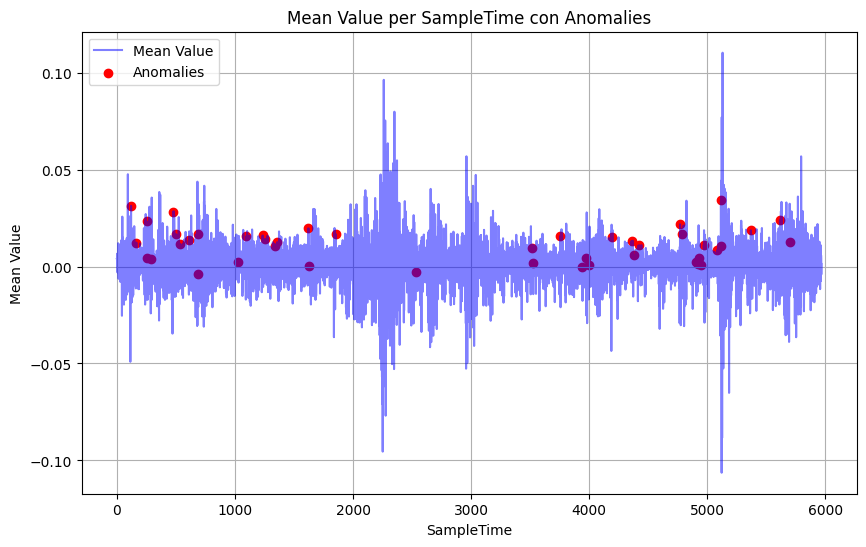

In [69]:
# Plot dei dati
plt.figure(figsize=(10, 6))
plt.plot(mean_values.index, mean_values.values, color='blue', alpha=0.5, label='Mean Value')
if anomalies:
    anomaly_times = pd.Series([1] * len(anomalies), index=anomalies)
    plt.scatter(anomaly_times.index, mean_values[anomalies], color='red', label='Anomalies')
plt.xlabel('SampleTime')
plt.ylabel('Mean Value')
plt.title('Mean Value per SampleTime con Anomalies')
plt.legend()
plt.grid(True)
plt.show()